# Classification Algorithm

Pada percobaan kali ini, kita akan melakukan komparasi antara dua algoritma *classification* untuk mencari tahu apakah seorang nasabah akan melakukan *deposit* atau tidak. Dua algoritma yang saya pilih adalah Decision Tree dan Naive Bayes.

## Mempersiapkan Data

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [145]:
df = pd.read_csv('bank.csv')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [146]:
#mengecek tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
age          11162 non-null int64
job          11162 non-null object
marital      11162 non-null object
education    11162 non-null object
default      11162 non-null object
balance      11162 non-null int64
housing      11162 non-null object
loan         11162 non-null object
contact      11162 non-null object
day          11162 non-null int64
month        11162 non-null object
duration     11162 non-null int64
campaign     11162 non-null int64
pdays        11162 non-null int64
previous     11162 non-null int64
poutcome     11162 non-null object
deposit      11162 non-null object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


Dari fungsi di atas, ditunjukkan bahwa terdapat 7 kolom yang mengandung data bertipe angka (int64), yaitu *age*, *balance*, *day*, *duration*, *campaign*, *pdays*, dan *previous*. Sementara, sisanya merupakan data dengan tipe obyek (object). Artinya, perlu ada pertimbangan secara numerikal dan kategorikal terhadap data tersebut.

### Pertimbangan Numerikal
Untuk menganalisis secara numerik, kita dapat mencari rerata, standar deviasi, serta nilai maksimal dan minimum dari dataset.

In [147]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0
balance,11162.0,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.00,81204.0
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330407,108.758282,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0


Selanjutnya, untuk mengeksplorasi data, dari deskripsi di atas kita buang variabel yang sekiranya tidak relevan. Dalam kasus ini, *day* diasumsikan tidak relevan karena hanya merupakan *timestamp* dari aktivitas deposit. Sementara *duration* merupakan durasi deposit yang dilakukan, dan karena kita hanya berniat untuk memprediksi apakah seseorang akan melakukan deposit atau tidak (tidak sampai berapa lama), *duration* juga bisa diabaikan. Kemudian, *pdays* merupakan data yang membingungkan karena terdapat *value* -1 yang sangat banyak. Karena itu, kita juga tidak akan menggunakan *pdays*.

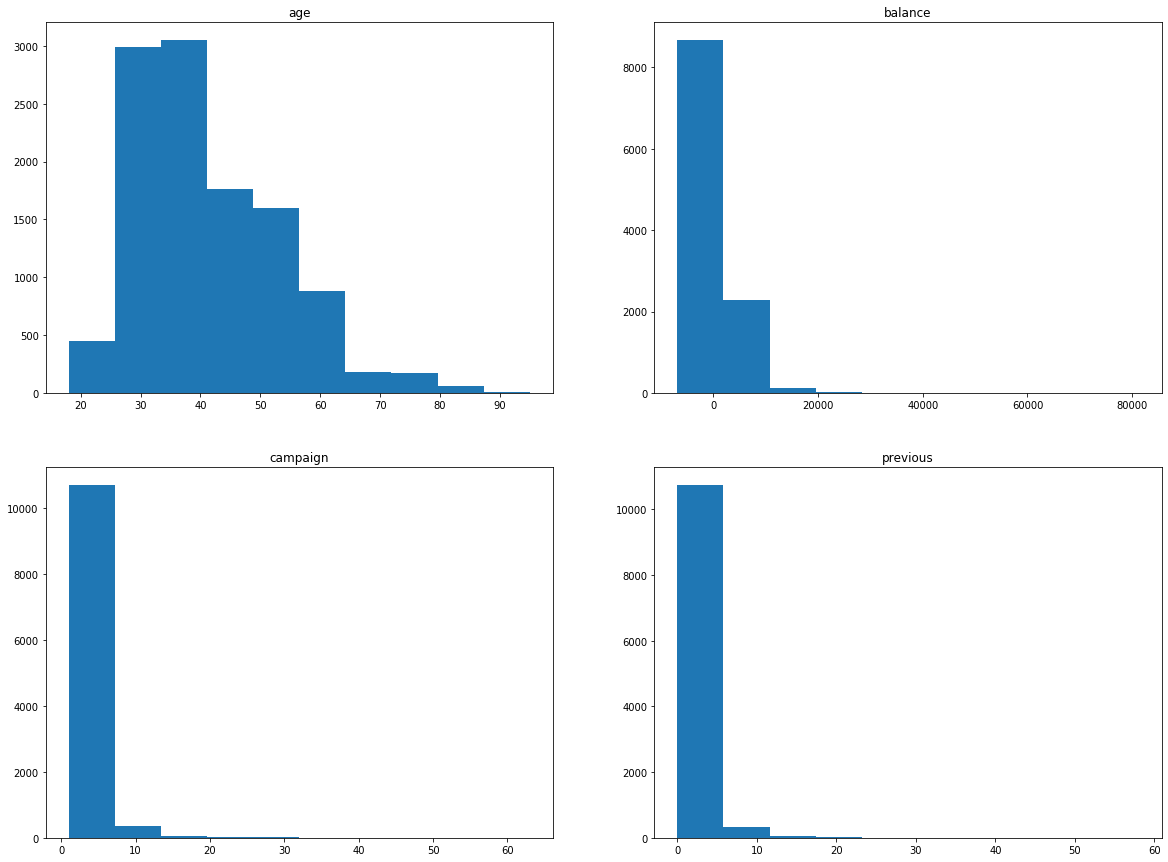

In [148]:
kol_angka = ['age', 'balance', 'campaign', 'previous']

fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for kol in kol_angka:
    
    trace_x = counter // 2
    trace_y = counter % 2
    
    axs[trace_x, trace_y].hist(df[kol])
    
    axs[trace_x, trace_y].set_title(kol)
    
    counter += 1

plt.show()

Dari hasil *plot*, dapat dilihat bahwa terdapat beberapa *outlier* yang ada pada variabel *campaign* dan *previous*. *Outlier* adalah data yang berada sangat jauh dari tren data lainnya dan berpotensi menimbulkan *noise* atau gangguan pada model kita. Untuk itu, 2 variabel ini perlu diingat kedepannya untuk selanjutnya dibersihkan untuk meraih hasil model yang lebih baik. Terdapat beberapa cara meng-*handle* gangguan ini, yaitu dengan melakukan *drop* atau mengganti nilai dengan *median*. Namun lebih baik menggunakan *median* agar tidak terlalu banyak data yang dibuang dari dataset ini.

### Pertimbangan Kategorikal

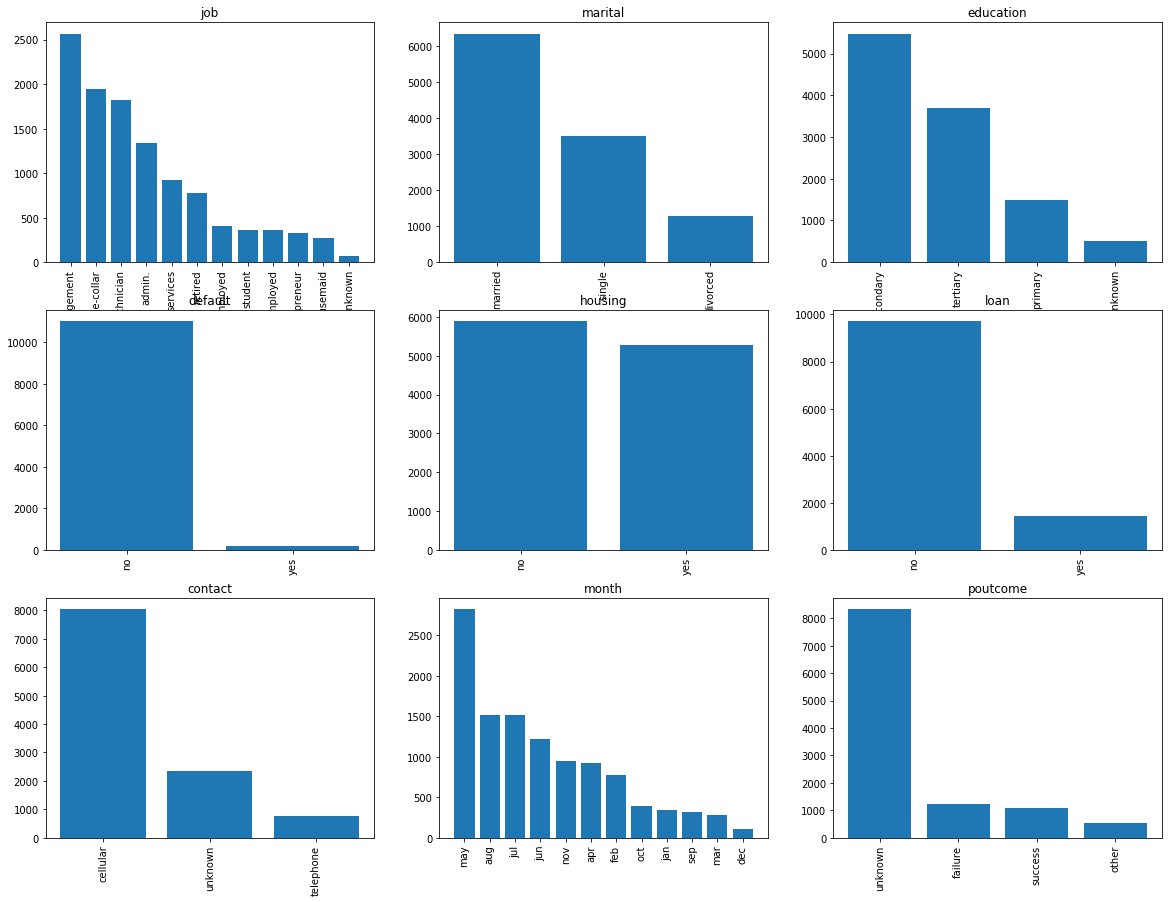

In [149]:
kol_kat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for kol in kol_kat:
    value_counts = df[kol].value_counts()
    
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    
    axs[trace_x, trace_y].set_title(kol)
    
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

plt.show()

Dari plot di atas, ada variabel yang perlu dibuang karena tidak relevan, yaitu *month* karena hanya merupakan *timestamp*. *default* dan *loan* juga sebaiknya dibuang, karena ketidakseimbangan input yang berpotensi mengganggu model. Sementara *poutcome* lebih baik dibuang karena data yang menjadi mayoritas justru berlabel *unknown*.

### Korelasi Variabel Dependen dan Independen

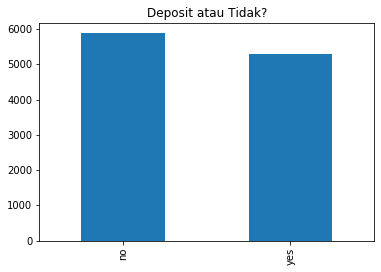

In [150]:
dependen = df['deposit'].value_counts()

dependen.plot.bar(title = 'Deposit atau Tidak?')

Dari *plot* tersebut, dapat dilihat bahwa jumlah nasabah yang melakukan dan tidak melakukan deposit mendekati 50:50, sehingga dalam kasus ini, kita dapat menggunakan **accuracy** untuk menampilkan kualitas model kita. Selanjutnya, kita coba membandingkan variabel dependen dengan seluruh variabel independen untuk mempertimbangkan variabel mana saja yang perlu kita gunakan sebagai model.

#### Numerikal 1: Age dan Deposit
Untuk umur dan data lainnya yang bersifat numerik, karena itu kita menggunakan *describe* untuk melihat tendensi pada yes dan pada no.

In [151]:
df_age = pd.DataFrame()
df_age['age_yes'] = (df[df['deposit'] == 'yes'][['deposit','age']].describe())['age']
df_age['age_no'] = (df[df['deposit'] == 'no'][['deposit','age']].describe())['age']

df_age

,age_yes,age_no
count,5289.000000,5873.000000
mean,41.670070,40.837391
std,13.497781,10.264815
min,18.000000,18.000000
25%,31.000000,33.000000
50%,38.000000,39.000000
75%,50.000000,48.000000
max,95.000000,89.000000


Secara sekilas, dapat kita lihat bahwa rata-rata usia nasabah yang melakukan deposit sedikit lebih besar dibandingkan yang tidak melakukan deposit.

#### Numerikal 2: Balance dan Deposit

In [152]:
df_bln = pd.DataFrame()
df_bln['balance_yes'] = (df[df['deposit'] == 'yes'][['deposit','balance']].describe())['balance']
df_bln['balance_no'] = (df[df['deposit'] == 'no'][['deposit','balance']].describe())['balance']

df_bln

,balance_yes,balance_no
count,5289.000000,5873.000000
mean,1804.267915,1280.227141
std,3501.104777,2933.411934
min,-3058.000000,-6847.000000
25%,210.000000,64.000000
50%,733.000000,414.000000
75%,2159.000000,1324.000000
max,81204.000000,66653.000000


Berdasarkan data di atas, dapat dilihat bahwa nasabah yang melakukan deposit memiliki rata-rata isi rekening yang jauh lebih besar dibandingkan yang tidak melakukan deposit.

#### Numerikal 3: Campaign dan Deposit

In [153]:
df_cmp = pd.DataFrame()
df_cmp['campaign_yes'] = (df[df['deposit'] == 'yes'][['deposit','campaign']].describe())['campaign']
df_cmp['campaign_no'] = (df[df['deposit'] == 'no'][['deposit','campaign']].describe())['campaign']

df_cmp

,campaign_yes,campaign_no
count,5289.000000,5873.000000
mean,2.141047,2.839264
std,1.921826,3.244474
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,32.000000,63.000000


Dari data tersebut, dapat disimpulkan bahwa nasabah yang melakukan deposit justru lebih jarang dikontak pada *campaign* ini. Artinya, dapat diasumsikan bahwa semakin sering bank mengontak nasabah untuk mengampanyekan deposit, justru peluang nasabah melakukan deposit justru mengecil.

#### Numerikal 4: Previous dan Deposit

In [154]:
df_pre = pd.DataFrame()
df_pre['previous_yes'] = (df[df['deposit'] == 'yes'][['deposit','previous']].describe())['previous']
df_pre['previous_no'] = (df[df['deposit'] == 'no'][['deposit','previous']].describe())['previous']

df_pre

,previous_yes,previous_no
count,5289.000000,5873.00000
mean,1.170354,0.52835
std,2.553272,1.97961
min,0.000000,0.00000
25%,0.000000,0.00000
50%,0.000000,0.00000
75%,1.000000,0.00000
max,58.000000,41.00000


Data *previous* ini cukup menarik karena efeknya berkebalikan dengan *campaign*. Karena, nasabah yang melakukan deposit justru merupakan nasabah yang lebih sering dikontak pada masa kampanye sebelumnya. Artinya, kemungkinan besar kampanye sebelumnya lebih efektif dari kampanye saat ini.

#### Kategorikal 1: Job dan Deposit

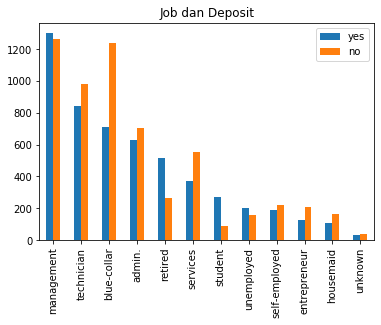

In [155]:
df_job = pd.DataFrame()

df_job['yes'] = df[df['deposit'] == 'yes']['job'].value_counts()
df_job['no'] = df[df['deposit'] == 'no']['job'].value_counts()

df_job.plot.bar(title = 'Job dan Deposit')

Dari visualisasi di atas, dapat dilihat bahwa pada setiap pekerjaannya, terdapat tendensi untuk melakukan deposit atau tidaknya. Misalnya, pada pekerjaan *blue-collar* dan *services*, besar kemungkinannya pekerja di bidang ini tidak melakukan deposit, namun untuk *retired* dan *student*, lebih besar kemungkinannya untuk melakukan deposit.

#### Kategorikal 2: Marital dan Deposit

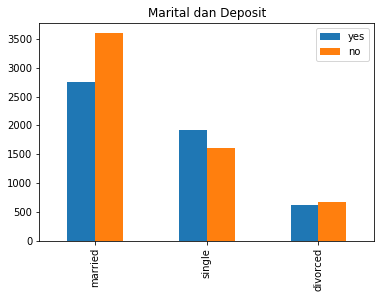

In [156]:
df_mrg = pd.DataFrame()

df_mrg['yes'] = df[df['deposit'] == 'yes']['marital'].value_counts()
df_mrg['no'] = df[df['deposit'] == 'no']['marital'].value_counts()

df_mrg.plot.bar(title = 'Marital dan Deposit')

Dari visualisasi di atas, dapat dilihat bahwa nasabah yang berstatus *married* dan *divorced* memiliki kecenderungan untuk tidak melakukan deposit, sementara yang berstatus *single* lebih cenderung melakukan deposit.

#### Kategorikal 3: Education dan Deposit

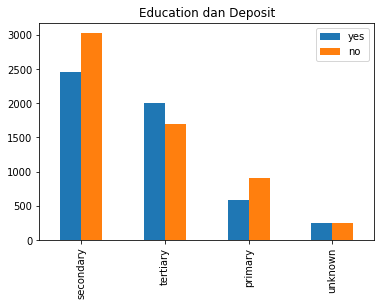

In [157]:
df_edu = pd.DataFrame()

df_edu['yes'] = df[df['deposit'] == 'yes']['education'].value_counts()
df_edu['no'] = df[df['deposit'] == 'no']['education'].value_counts()

df_edu.plot.bar(title = 'Education dan Deposit')

Dari visualisasi di atas, ditunjukkan bahwa nasabah yang telah menjalani pendidikan *secondary* dan *primary* lebih cencderung tidak melakukan deposit, sementara yang *tertiary* lebih cenderung melakukan deposit.

#### Kategorikal 4: Housing dan Deposit

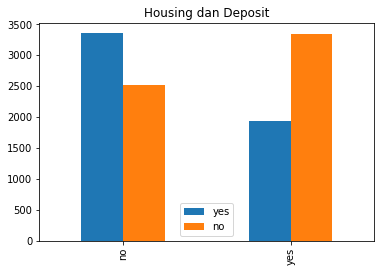

In [158]:
df_hou = pd.DataFrame()

df_hou['yes'] = df[df['deposit'] == 'yes']['housing'].value_counts()
df_hou['no'] = df[df['deposit'] == 'no']['housing'].value_counts()

df_hou.plot.bar(title = 'Housing dan Deposit')

Dari visualisasi di atas, dapat dilihat bahwa nasabah yang memiliki rumah cenderung tidak melakukan deposit, sementara nasabah yang tidak memiliki rumah lebih cenderung melakukan deposit.

#### Kategorikal 5: Contact dan Deposit

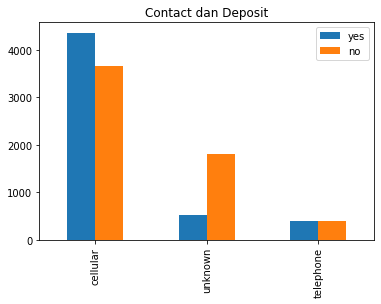

In [159]:
df_con = pd.DataFrame()

df_con['yes'] = df[df['deposit'] == 'yes']['contact'].value_counts()
df_con['no'] = df[df['deposit'] == 'no']['contact'].value_counts()

df_con.plot.bar(title = 'Contact dan Deposit')

Dari visualisasi di atas, dapat dilihat bahwa nasabah yang dikontak via *cellular* lebih banyak yang akhirnya melakukan deposit.

### Data Cleaning
Menanggapi asumsi-asumsi dan variabel yang telah kita buang dari dataset utama kita, ada baiknya kita membersihkan data kita untuk menghasilkan model yang optimal.

In [160]:
# drop variabel yang tidak dibutuhkan
df_drop = df.drop(['day', 'duration', 'pdays', 'month', 'default', 'loan', 'poutcome'], axis=1)
df_drop

,age,job,marital,education,balance,housing,contact,campaign,previous,deposit
0,59,admin.,married,secondary,2343,yes,unknown,1,0,yes
1,56,admin.,married,secondary,45,no,unknown,1,0,yes
2,41,technician,married,secondary,1270,yes,unknown,1,0,yes
3,55,services,married,secondary,2476,yes,unknown,1,0,yes
4,54,admin.,married,tertiary,184,no,unknown,2,0,yes
...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,1,yes,cellular,1,0,no
11158,39,services,married,secondary,733,no,unknown,4,0,no
11159,32,technician,single,secondary,29,no,cellular,2,0,no
11160,43,technician,married,secondary,0,no,cellular,2,5,no


In [161]:
# mengganti outlier dengan median

def get_correct_values(row, column_name, threshold, df):
    if row[column_name] <= threshold:
        return row[column_name]
    else:
        median = df_drop[df_drop[column_name] <= threshold][column_name].median()
        return median


df_drop['campaign_cleaned'] = df_drop.apply(lambda row: get_correct_values(row, 'campaign', 34, df_drop),axis=1)
df_drop['previous_cleaned'] = df_drop.apply(lambda row: get_correct_values(row, 'previous', 34, df_drop),axis=1)
df_no_outlier = df_drop.drop(['campaign', 'previous'], axis=1)
df_no_outlier

,age,job,marital,education,balance,housing,contact,deposit,campaign_cleaned,previous_cleaned
0,59,admin.,married,secondary,2343,yes,unknown,yes,1.0,0.0
1,56,admin.,married,secondary,45,no,unknown,yes,1.0,0.0
2,41,technician,married,secondary,1270,yes,unknown,yes,1.0,0.0
3,55,services,married,secondary,2476,yes,unknown,yes,1.0,0.0
4,54,admin.,married,tertiary,184,no,unknown,yes,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,1,yes,cellular,no,1.0,0.0
11158,39,services,married,secondary,733,no,unknown,no,4.0,0.0
11159,32,technician,single,secondary,29,no,cellular,no,2.0,0.0
11160,43,technician,married,secondary,0,no,cellular,no,2.0,5.0


In [162]:
# One Hot Encoding

# Import Module
from sklearn.preprocessing import OneHotEncoder

# Encoder
encoder = OneHotEncoder(sparse=False)

kategorikal = ['job', 'marital', 'education', 'housing', 'contact']

# Encode Categorical Data
df_encoded = pd.DataFrame(encoder.fit_transform(df_no_outlier[kategorikal]))
df_encoded.columns = encoder.get_feature_names(kategorikal)

# Replace Categorical Data with Encoded Data
df_no_outlier.drop(kategorikal ,axis=1, inplace=True)
df_encoded= pd.concat([df_no_outlier, df_encoded], axis=1)

# Show Encoded Dataframe
df_encoded

,age,balance,deposit,campaign_cleaned,previous_cleaned,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,housing_no,housing_yes,contact_cellular,contact_telephone,contact_unknown
0,59,2343,yes,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,56,45,yes,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,41,1270,yes,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,55,2476,yes,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,54,184,yes,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,1,no,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
11158,39,733,no,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
11159,32,29,no,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
11160,43,0,no,2.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


Setelah melakukan pembersihan di atas, sekarang kita memiliki sebuah dataframe yang variabel kategorikalnya sudah di-*encode* dan *outlier*-nya telah diganti dengan median. Artinya, dataframe terbaru kita seharusnya sudah berisi variabel numerikal saja, kecuali pada variabel *deposit*.

In [163]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 29 columns):
age                    11162 non-null int64
balance                11162 non-null int64
deposit                11162 non-null object
campaign_cleaned       11162 non-null float64
previous_cleaned       11162 non-null float64
job_admin.             11162 non-null float64
job_blue-collar        11162 non-null float64
job_entrepreneur       11162 non-null float64
job_housemaid          11162 non-null float64
job_management         11162 non-null float64
job_retired            11162 non-null float64
job_self-employed      11162 non-null float64
job_services           11162 non-null float64
job_student            11162 non-null float64
job_technician         11162 non-null float64
job_unemployed         11162 non-null float64
job_unknown            11162 non-null float64
marital_divorced       11162 non-null float64
marital_married        11162 non-null float64
marital_single        

Dari visualisasi di atas, dapat dibuktikan bahwa semua variabel kecuali *deposit* telah berubah jadi numerik. Selanjutnya, *deposit* kita pisahkan dari dataframe karena *deposir* merupakan label yang akan digunakan pada model kita.

In [164]:
feature = df_encoded.drop(['deposit'], axis=1)
feature

,age,balance,campaign_cleaned,previous_cleaned,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,housing_no,housing_yes,contact_cellular,contact_telephone,contact_unknown
0,59,2343,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,56,45,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,41,1270,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,55,2476,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,54,184,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
11158,39,733,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
11159,32,29,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
11160,43,0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [165]:
# mengubah deposit menjadi 1 dan not deposit menjadi 0
target = pd.get_dummies(df_encoded['deposit'], drop_first=True)
target

,yes
0,1
1,1
2,1
3,1
4,1
...,...
11157,0
11158,0
11159,0
11160,0


### Train Test Split

Setelah itu, kita membagi *feature* dan *target* dengan ketentuan 70% digunakan untuk *training* model, sementara 30% untuk *testing* model.

In [166]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test  = train_test_split(feature , target, shuffle = True, test_size=0.3, random_state=1)

# Show the Training and Testing Data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7813, 28)
(3349, 28)
(7813, 1)
(3349, 1)


## Model Building: Decision Tree

In [167]:
# Import Module
from sklearn import tree

# Modeling Decision Tree
dtc = tree.DecisionTreeClassifier(min_impurity_decrease=0.01)
dtc.fit(X_train, y_train)

# Predict to Test Data 
y_pred_dtc = dtc.predict(X_test)

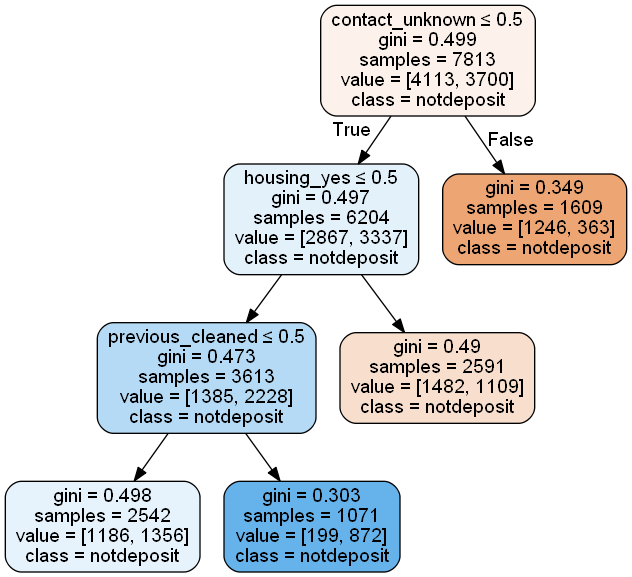

In [168]:
# Visualize Tree

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dtc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                class_names=['notdeposit', 'notdeposit'],
                feature_names=['age',	'balance',	'campaign_cleaned', 'previous_cleaned',	'job_admin', 'job_blue-collar',	'job_entrepreneur',	'job_housemaid',
                               'job_management',	'job_retired',	'job_self-employed',	'job_services',	'job_student', 'job_technician',
                               'job_unemployed',	'job_unknown', 'marital_divorced', 'marital_married',	'marital_single',
                               'education_primary',	'education_secondary',	'education_tertiary', 'education_unknown',
                               'housing_no',	'housing_yes',	'contact_cellular',	'contact_telephone',	'contact_unknown'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Confusion Matrix

In [169]:
# Import Module
from sklearn import metrics

# Show the Confussion Matrix
cm_dtc = metrics.confusion_matrix(y_test, y_pred_dtc)
cm_dtc

array([[1117,  643],
       [ 621,  968]], dtype=int64)

### Accuracy, Precision, Recall, F1 Score, Cohens Kappa Score

In [170]:
# Show the Accuracy, Precision, Recall
acc_dtc = metrics.accuracy_score(y_test, y_pred_dtc)
prec_dtc = metrics.precision_score(y_test, y_pred_dtc)
rec_dtc = metrics.recall_score(y_test, y_pred_dtc)
f1_dtc = metrics.f1_score(y_test, y_pred_dtc)
kappa_dtc = metrics.cohen_kappa_score(y_test, y_pred_dtc)

print("Accuracy:", acc_dtc)
print("Precision:", prec_dtc)
print("Recall:", rec_dtc)
print("F1 Score:", f1_dtc)
print("Cohens Kappa Score:", kappa_dtc)

Accuracy: 0.6225739026575097
Precision: 0.6008690254500311
Recall: 0.6091881686595343
F1 Score: 0.6050000000000001
Cohens Kappa Score: 0.243683359889027


### ROC Curve

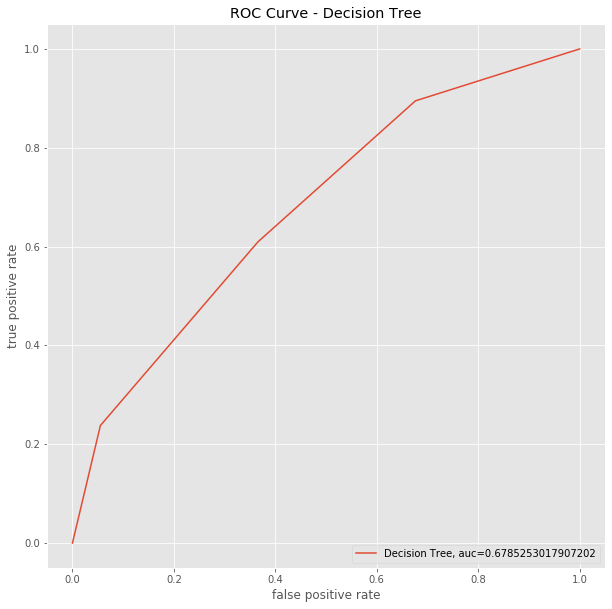

In [171]:
# Import Visualization Package
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set Size and Style
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

# Visualize ROC Curve
y_pred_dtc_proba = dtc.predict_proba(X_test)[::,1]
fprdtc, tprdtc, _ = metrics.roc_curve(y_test,  y_pred_dtc_proba)
aucdtc = metrics.roc_auc_score(y_test, y_pred_dtc_proba)
plt.plot(fprdtc,tprdtc,label="Decision Tree, auc="+str(aucdtc))
plt.title('ROC Curve - Decision Tree')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

## Model Building: Naive Bayes

In [172]:
# Import Module
from sklearn.naive_bayes import GaussianNB 

# Modeling Naive Bayes Classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predict to Test Data
y_pred_gnb= gnb.predict(X_test)

### Confusion Matrix

In [173]:
# Show the Confussion Matrix
cm_gnb = metrics.confusion_matrix(y_test, y_pred_gnb)
cm_gnb

array([[1180,  580],
       [ 578, 1011]], dtype=int64)

### Accuracy, Precision, Recall, F1 Score, Cohens Kappa Score

In [174]:
# Show the Accuracy, Precision, Recall
acc_gnb = metrics.accuracy_score(y_test, y_pred_gnb)
prec_gnb = metrics.precision_score(y_test, y_pred_gnb)
rec_gnb = metrics.recall_score(y_test, y_pred_gnb)
f1_gnb = metrics.f1_score(y_test, y_pred_gnb)
kappa_gnb = metrics.cohen_kappa_score(y_test, y_pred_gnb)

print("Accuracy:", acc_gnb)
print("Precision:", prec_gnb)
print("Recall:", rec_gnb)
print("F1 Score:", f1_gnb)
print("Cohens Kappa Score:", kappa_gnb)

Accuracy: 0.6542251418333831
Precision: 0.6354494028912634
Recall: 0.6362492133417244
F1 Score: 0.6358490566037737
Cohens Kappa Score: 0.30668500660216225


### ROC Curve

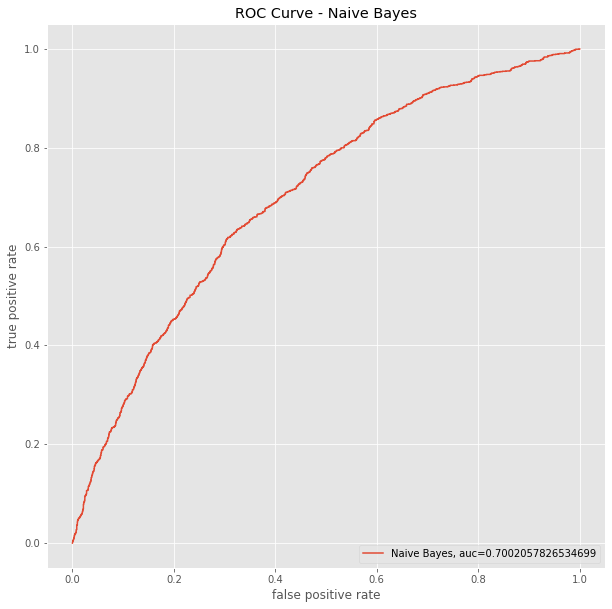

In [175]:
# ROC Curve
y_pred_gnb_proba = gnb.predict_proba(X_test)[::,1]
fprgnb, tprgnb, _ = metrics.roc_curve(y_test,  y_pred_gnb_proba)
aucgnb = metrics.roc_auc_score(y_test, y_pred_gnb_proba)
plt.plot(fprgnb,tprgnb,label="Naive Bayes, auc="+str(aucgnb))
plt.title('ROC Curve - Naive Bayes')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

## Model Comparison

In [176]:
# Comparing Model Performance
print("Decision Tree Accuracy =",acc_dtc)
print("Decision Tree Precision =",prec_dtc)
print("Decision Tree Recall =",rec_dtc)
print("Decision Tree F1-Score =", f1_dtc)
print("_______________________")
print("Naive Bayes Accuracy =", acc_gnb)
print("Naive Bayes Precision =", prec_gnb)
print("Naive Bayes Recall =", rec_gnb)
print("Naive Bayes F1-Score =", f1_gnb)

Decision Tree Accuracy = 0.6225739026575097
Decision Tree Precision = 0.6008690254500311
Decision Tree Recall = 0.6091881686595343
Decision Tree F1-Score = 0.6050000000000001
_______________________
Naive Bayes Accuracy = 0.6542251418333831
Naive Bayes Precision = 0.6354494028912634
Naive Bayes Recall = 0.6362492133417244
Naive Bayes F1-Score = 0.6358490566037737


Dari hasil pengecekan dengan akurasi, presisi, *recall*, dan F1, dalam kasus ini Naive Bayes lebih baik digunakan dibandingkan Decision Tree. Untuk lebih jelasnya dapat dilihat pada kurva ROC di bawah.

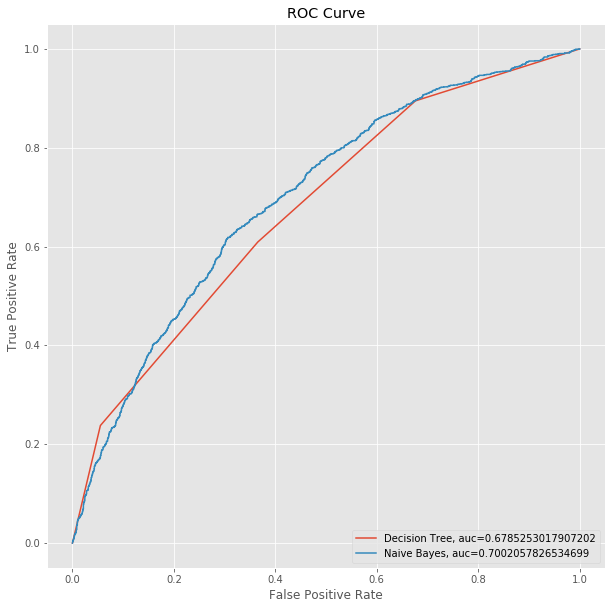

In [177]:
# Comparing ROC Curve
plt.plot(fprdtc,tprdtc,label="Decision Tree, auc="+str(aucdtc))
plt.plot(fprgnb,tprgnb,label="Naive Bayes, auc="+str(aucgnb))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

## Kesimpulan

Pada percobaan dengan asumsi dan variabel yang diatur seperti di atas, yaitu tidak mempertimbangkan variabel *month*, *default*, *loan*, *poutcome*, *day*, *duration*, dan *pdays*, serta menggantikan outlier dengan median, Naive Bayes lebih baik untuk digunakan daripada Decision Tree. Komparasi ini tentu hanya berlaku untuk kasus ini saja. Untuk kasus lainnya, dengan menambah atau mengurangi asumsi yang dilakukan, bisa jadi Decision Tree lebih baik digunakan. 

Dengan asumsi yang sudah dilakukan, akurasi dari kedua model berada di sekitar angka 60%. Ada baiknya untuk ke depannya dilakukan lebih banyak percobaan dengan menambah atau mengurangi asumsi untuk mencari akurasi yang lebih tinggi.